In [4]:
import numpy as np

def interval_projection(mu):
    if(mu < 0):
        mu = 0
    elif(mu >= 1):
        mu = 1
    return mu

# projects vector z onto all vectors living in [0,1]^f
# z_in is the ith column of the matrix C in hottopixx
def project_column(z_in, i):
    
    f = len(z_in)
    
    z = np.zeros(f)
    
    # have to sort the remaining elements of z for the algorithm
    # and keep track of where each index went
    # the [::-1] makes sure this is the decreasing order
    ind = np.argsort(z_in)[::-1]
    # but regardless of the sorting, the diagonal element has to be first
    ind = ind[ ind != i ]
    ind = np.insert(ind,0,i)
    z = z_in[ind]
    
    # initialize projection vector x
    x = np.zeros(f)   
    
    mu = z[0]
   
    kc = 0
    for k in range(1,f):
        if(z[k] <= interval_projection(mu)):
            kc = k - 1
            break
        else:
            mu = (k-1)/k * mu + 1/k * z[k]

    x[0] = interval_projection(mu)
    for k in range(0,kc):
        x[k] = interval_projection(mu)
    for k in range(kc+1, f):
        # assign the positive part of z[k]
        x[k] = z[k] if (z[k] > 0) else 0

    # reverse the permutations of the original elements
    ind = np.argsort(ind)
    x = x[ind]

    return x
    
# helper function for hottopixx below
def project_on_phi(C):
    (f,f) = C.shape
    mu = np.zeros(f)
    for i in range(f):
        z = C[:,i]
        C[:,i] = project_column(z, i)
    return C

In [5]:
# step 11 in hottopixx
def extract_col(C):
    (f,f) = C.shape
    I = []
    num_ones = 0
    for i in range(f):
        if(C[i,i] == 1):
            I.append(i)
            num_ones += 1
    return I, num_ones

In [6]:
import math

# X is the non-negative data matrix, f by n
# expects X's rows to sum to 1
# r is the dimension of the NMF, i.e. X = FW where F is f by r, W is r by n

def hottopixx(X,r):
    
    # get dimensions of data matrix (Careful: X is features times samples, different than usual)
    (f,n) = X.shape
    
    # primal and dual stepsizes
    sp = 1e-1
    sd = 1e-2

    # initialize cost vector randomly (does this have to be a positive vector?)
    p = np.random.rand(f)

    # 'one' vector
    one = np.ones(f)
    
    # mu vector, mu[i] is the number of non-zero entries (in X or C?)
    mu = np.ones(f)
    
    # C is f by f
    C = np.zeros((f,f))
    
    beta = 0
    
    # number of epochs
    N_ep = 1000
    
    for t in range(N_ep):
        
        # do an epoch
        for i in range(n):
            
            # choose random column of data matrix
            k = math.floor(np.random.rand() * n)
            Xk = X[:,k].reshape(f,1)
            # term in the sign function (see paper)
            term1 = np.sign(Xk - np.dot(C,Xk))
            # incremental gradient descent step, (potentially add the mu factor here)
            C = C + sp * np.dot(term1, Xk.T) - sp * np.diag((beta * one - p))
        # project C onto Phi_0
        C = project_on_phi(C)
        # update beta
        beta = beta + sd * (np.trace(C) - r)
        
    # now, we have selected the most salient features of the data matrix.
    # Let's extract and return them:
    I, num_ones = extract_col(C)
    F = C[:,I]
    W = X[I,:]
    #print(np.diag(C))
    print('number of hottopixx found: ' + str(num_ones))
    return F, W

In [7]:
# normalizes non-negative X row-wise
def row_normalize(X):
    for i in range(X.shape[0]):
        row_sum = X[i].sum()
        X[i] = X[i]/row_sum
    return X

In [8]:
import wave
import matplotlib.mlab as mlab
from sklearn import preprocessing

# computes power and l2 normalized spectrogram from .wav file
def wav_to_spect(filename):
    # import sample soundfile and get it ready for kmeans
    w = wave.open(filename, "rb")

    waveParams = w.getparams()
    s = w.readframes(waveParams[3])
    w.close()
    waveArray = np.fromstring(s, np.int16)
    
    spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256, Fs = waveParams[2], sides = 'onesided')

    (n,m) = spectrum.shape
    
    # power normalization 
    for i in range(n):
        for j in range(m):
            spectrum[i,j] = np.sqrt(spectrum[i,j])

    # l2 normalization
    preprocessing.normalize(spectrum, norm = 'l2', axis = 1, copy = False)

    return spectrum

In [13]:
X = np.random.rand(3,5)
X = row_normalize(X)

In [14]:
np.savetxt("X.tsv", X, delimiter = '\t', newline = '\n' )

In [589]:
import time
start = time.time()
F,W = hottopixx(X,30)
end = time.time()
print(end-start)

[ 0.06167466  1.          1.          0.06359649  0.06418499  1.
  0.07823604  0.03292089  0.07389511  0.07453211  0.06379164  0.08358108
  1.          0.06355391  1.          0.08277986  1.          0.03974574
  0.06682618  0.05145228  0.08304687  0.08475537  0.05972625  0.07325193
  0.06452291  0.05369627  0.05778829  0.04318103  0.06019314  0.04510099
  0.0733751   0.04514393  0.08536761  0.0661271   1.          0.05689076
  0.08751247  0.07093722  1.          0.05663606  0.08934751  0.04460133
  1.          0.09130883  1.          1.          0.06352689  0.04287782
  0.0489692   1.          1.          0.06530096  0.05465004  0.04663404
  1.          0.07980866  0.05031084  1.          0.08526564  0.04893781
  1.          1.          0.07856928  1.          0.108563    0.05148659
  0.09608442  0.11188698  0.03195004  0.05259868  0.05904399  0.05928603
  0.0577429   0.05711509  0.04087195  1.          0.08822425  1.          0.0718375
  1.          0.08690466  0.05761321  0.08229948

In [590]:
F

array([[  4.12319812e-01,   2.37305169e-01,   2.88670031e-01, ...,
          1.61894630e-02,   0.00000000e+00,   5.04335185e-02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.79001124e-03,   0.00000000e+00,   6.34406126e-03],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  8.76829628e-02,   0.00000000e+00,   2.19733878e-01, ...,
          1.59791647e-01,   1.86722366e-04,   0.00000000e+00],
       [  1.20495260e-01,   0.00000000e+00,   4.73769258e-02, ...,
          0.00000000e+00,   7.62885322e-01,   4.46973523e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   3.42076642e-01]])

In [9]:
spect = wav_to_spect('train.wav')
print(spect.shape)

(129, 41131)


In [10]:
np.savetxt("spect.tsv", spect, delimiter = '\t', newline = '\n' )

In [592]:
# to speed up the computation, lets downsample for now (Cédric Févotte samples at 11kHz, while this recording is at 44.1kHz)
spect2 = spect[:,0:spect.shape[1]:40]
print(spect2.shape)
spect2 = row_normalize(spect2)

(129, 1029)


In [606]:
# Anything below 70 returns non-sensical values
import time
start = time.time()
F,W = hottopixx(spect2,70)
end = time.time()
print(end-start)

[ 1.          0.17031393  0.1494879   1.          1.          0.09968434
  1.          1.          0.11151226  0.1213821   0.10989163  1.
  0.10466324  1.          1.          0.09844468  1.          0.13635795
  0.10905873  1.          1.          1.          0.08168864  0.10030063
  0.09869733  1.          0.05097285  1.          1.          0.07212907
  0.05288313  0.09532182  0.05921396  1.          1.          0.04236489
  0.05284964  1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.05279188  1.          0.06143447
  0.08760213  0.08204593  0.09656134  0.12138481  1.          0.09901281
  1.          1.          0.16466243  0.13591287  0.16288352  1.
  0.15609421  1.          1.          1.          1.          0.14896122
  0.17628856  0.12628027  0.17100116  1.          0.09777623  1.          1.
  1.          1.          0.11836214  1.          1.          1.          1.
  1.          0.06496446  1.          0.06077733  0.039

In [608]:
W.shape

(63, 1029)

In [609]:
# save the result to a file
np.save("F_train", F)
np.save("W_train", W)

In [611]:
# Frobenius norm of difference between data and factorization
print('Frobenius: ' + str(np.linalg.norm(spect2-np.dot(F,W))))
# Norm in paper
print('INF-1: ' + str(max(np.sum(abs(spect2-np.dot(F,W)), axis = 1))))

Frobenius: 5.14612045001
INF-1: 21.0726263542


In [612]:
F_train = np.load("F_train.npy")
W_train = np.load("W_train.npy")

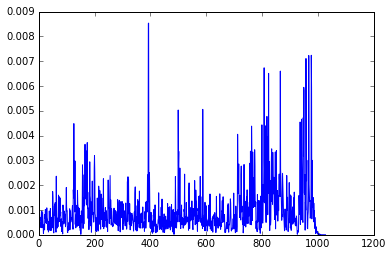

In [613]:
# row of W
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(W_train.shape[1]), W_train[1,:])

In [614]:
W_train.shape

(63, 1029)

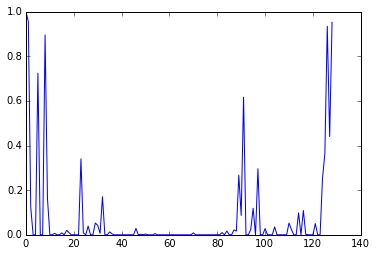

In [615]:
# row of F
plt.plot(range(F_train.shape[0]), F_train[:,0])

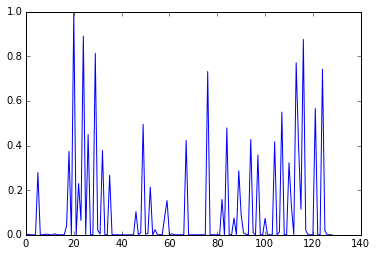

In [618]:
plt.plot(range(F_train.shape[0]), F_train[:,10])